## Import libraries

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = 'cpu'

## Load a single image from MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)

# Pick a specific image
x_0, _ = dataset[0]
x_0 = x_0.to(device)

# Function to show image
def show_image(tensor, title=""):
    img = tensor.cpu().squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")    

## Define the Noise Schedule

In [3]:
TIMESTEPS = 200

# Define beta (β)
beta = torch.linspace(0.0001, 0.02, TIMESTEPS).to(device)

# Calculate alpha (α)
alpha = 1.0 - beta

# Calculate alpha bar (cumulative product of α)
alpha_bar = torch.cumprod(alpha, dim=0)

print(f"Schedule created for {TIMESTEPS} timesteps.")
print(f"Alpha bar at last step: {alpha_bar[-1]:.4f}")

Schedule created for 200 timesteps.
Alpha bar at last step: 0.1322


## The Forward Diffusion

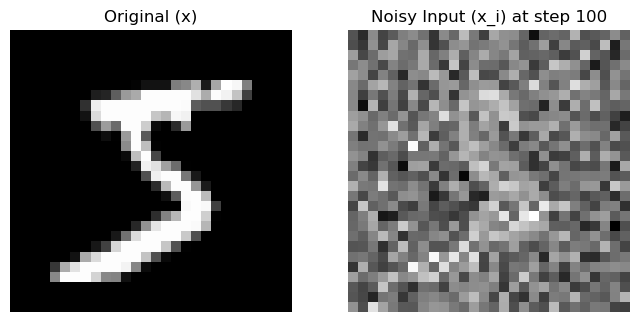

In [4]:
def forward_diffusion(x_0, t):
    """
    Takes clean image x_0 and returns noisy image x_t at timestep t.
    """
    noise = torch.randn_like(x_0)
    
    # Gather alpha_bar for timesteps t
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t])
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t])
    
    # The forward process equation
    x_t = (sqrt_alpha_bar_t * x_0) - (sqrt_one_minus_alpha_bar_t * noise)
    return x_t

# Let's generate a noisy image at step i = 100
i_step = 100
x_i = forward_diffusion(x_0, i_step)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); show_image(x_0, "Original (x)")
plt.subplot(1, 2, 2); show_image(x_i, f"Noisy Input (x_i) at step {i_step}")
plt.show()

## The Reverse Process

In [5]:
def get_posterior_mean_variance(x_i, x_0, t):
    """
    Calculates the mean and variance for p(x_{i-1} | x_i, x_0)
    using the Lemma 2.2.2 formula.
    """
    # Note: t is the index, so t corresponds to step i
    # We need t-1 for the previous alpha_bar

    # 1. Gather terms
    alpha_t = alpha[t]
    alpha_bar_t = alpha_bar[t]
    alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0).to(device)
    beta_t = beta[t]

    # 2. Calculate Coefficient 1 (for x_0)
    # Formula: (sqrt(alpha_bar_prev) * beta_t) / (1 - alpha_bar_t)
    coeff_1 = (torch.sqrt(alpha_bar_prev) * beta_t) / (1 - alpha_bar_t)

    # 3. Calculate Coefficient 2 (for x_i)
    # Formula: (sqrt(alpha_t) * (1 - alpha_bar_prev)) / (1 - alpha_bar_t)
    coeff_2 = (torch.sqrt(alpha_t) * (1 - alpha_bar_prev)) / (1 - alpha_bar_t)

    # 4. Calculate Mean mu
    mu = (coeff_1 * x_0) + (coeff_2 * x_i)

    # 5. Calculate Posterior Variance (sigma^2)
    # Formula: ((1 - alpha_bar_prev) / (1 - alpha_bar_t)) * beta_t
    posterior_variance = ((1 - alpha_bar_prev) / (1 - alpha_bar_t)) * beta_t

    return mu, posterior_variance

# Run the reverse transition
# We are at step i_step, we want to guess i_step - 1
mu_prev, var_prev = get_posterior_mean_variance(x_i, x_0, i_step)

print("Posterior Mean calculated.")

Posterior Mean calculated.


## Visualization

Denoising from step 50 down to 1...


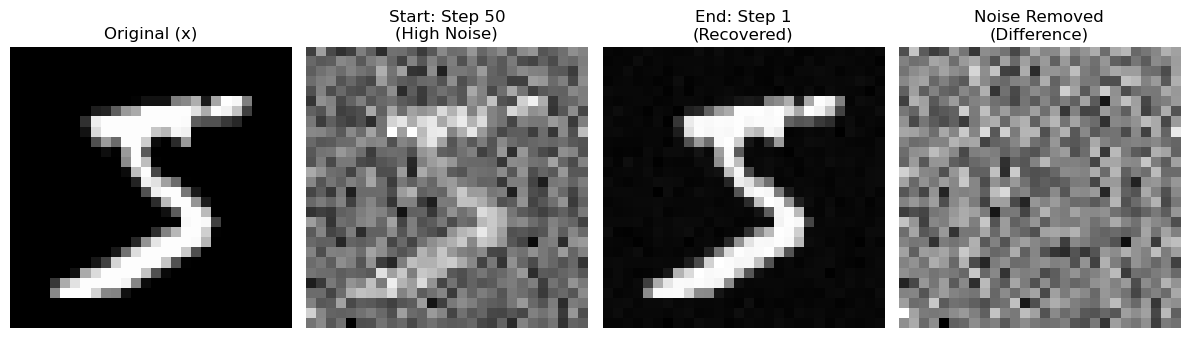

In [6]:
# 1. Start at High Noise (Step 100)
# We use forward_diffusion to get our starting point
start_step = 50
x_current = forward_diffusion(x_0, start_step)

# Store the starting point for comparison
x_start_img = x_current.clone()

# 2. Run the Reverse Transition Loop (100 -> 1)
# We apply the Gaussian formula repeatedly
print(f"Denoising from step {start_step} down to 1...")
for t in range(start_step, 0, -1):
    # Calculate mean and variance for the previous step (t-1)
    mu, var = get_posterior_mean_variance(x_current, x_0, t)

    # Sample from the Gaussian distribution
    noise = torch.randn_like(x_0)
    x_current = mu + (torch.sqrt(var) * noise)

# 3. Visualization
plt.figure(figsize=(12, 4))

# Plot 1: The Clean Original (Ground Truth)
plt.subplot(1, 4, 1)
show_image(x_0, "Original (x)")

# Plot 2: Where we started (Step 100) - Very Noisy
plt.subplot(1, 4, 2)
show_image(x_start_img, f"Start: Step {start_step}\n(High Noise)")

# Plot 3: The Result of the Reverse Process (Step 1)
plt.subplot(1, 4, 3)
show_image(x_current, f"End: Step 1\n(Recovered)")

# Plot 4: The Difference (Noise Removed)
# Showing what was subtracted
diff = x_start_img - x_current
plt.subplot(1, 4, 4)
show_image(diff, "Noise Removed\n(Difference)")

plt.tight_layout()
plt.show()